 ## Load Data

In [8]:
import pandas as pd
import os

# path to the covid 19 data folder
data_folder_path = os.path.expanduser('~/Desktop/sara individual work stage 2/covid 19 data')

# load merged set
covid_data_path = os.path.join(data_folder_path, 'final_merged_data.csv')
covid_data = pd.read_csv(covid_data_path)

# print
print(covid_data.head())


   countyFIPS      County Name State  StateFIPS_cases  2020-01-22_cases  \
0        1001  Autauga County     AL                1                 0   
1        1003  Baldwin County     AL                1                 0   
2        1005  Barbour County     AL                1                 0   
3        1007     Bibb County     AL                1                 0   
4        1009   Blount County     AL                1                 0   

   2020-01-23_cases  2020-01-24_cases  2020-01-25_cases  2020-01-26_cases  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   2020-01-27_cases  ...  2023-07-15_deaths  2023-07-16_deaths  \
0                 0 

## Step 1&2: Filter for New York and Calculate Weekly Statistics

In [33]:
import pandas as pd

# filtering the data for New York
ny_data = covid_data[covid_data['State'] == 'NY']


# reshaping to long format for cases and deaths
ny_cases_long = ny_data.melt(
    id_vars=['countyFIPS', 'County Name', 'State', 'population'],
    value_vars=[col for col in ny_data.columns if '_cases' in col and 'StateFIPS' not in col],
    var_name='date',
    value_name='cases'
)
ny_cases_long['date'] = ny_cases_long['date'].str.replace('_cases', '')

ny_deaths_long = ny_data.melt(
    id_vars=['countyFIPS', 'County Name', 'State', 'population'],
    value_vars=[col for col in ny_data.columns if '_deaths' in col and 'StateFIPS' not in col],
    var_name='date',
    value_name='deaths'
)
ny_deaths_long['date'] = ny_deaths_long['date'].str.replace('_deaths', '')


# merging cases and deaths into a single df
ny_long_data = pd.merge(ny_cases_long, ny_deaths_long, on=['countyFIPS', 'County Name', 'State', 'population', 'date'])

# converting 'date' to datetime
ny_long_data['date'] = pd.to_datetime(ny_long_data['date'], format='%Y-%m-%d', errors='coerce')

# seting the date as the index
ny_long_data.set_index('date', inplace=True)

# removing double entries by grouping by date & summing cases and deaths
ny_long_data = ny_long_data.groupby(ny_long_data.index).sum()

# calc daily new cases & deaths 
ny_long_data['cases'] = ny_long_data['cases'].diff().fillna(0)
ny_long_data['deaths'] = ny_long_data['deaths'].diff().fillna(0)

# no negative values
ny_long_data['cases'] = ny_long_data['cases'].clip(lower=0)
ny_long_data['deaths'] = ny_long_data['deaths'].clip(lower=0)

# resample the data to weekly frequency & sum cases and deaths
weekly_ny_data = ny_long_data.resample('W').sum()

# stats
weekly_mean = weekly_ny_data[['cases', 'deaths']].mean()
weekly_median = weekly_ny_data[['cases', 'deaths']].median()
weekly_mode = weekly_ny_data[['cases', 'deaths']].mode().iloc[0] if not weekly_ny_data[['cases', 'deaths']].mode().empty else {'cases': float('nan'), 'deaths': float('nan')}

# printing
print(f"Weekly Mean (New York): \n{weekly_mean}\n")
print(f"Weekly Median (New York): \n{weekly_median}\n")
print(f"Weekly Mode (New York): \n{weekly_mode}\n")


Weekly Mean (New York): 
cases     36646.939891
deaths      427.256831
dtype: float64

Weekly Median (New York): 
cases     25852.0
deaths      179.0
dtype: float64

Weekly Mode (New York): 
cases     0.0
deaths    0.0
Name: 0, dtype: float64



In the first two steps, I start by narrowing down the dataset to only include covid information from New York. This way, all the calculations I do next are specific to that state.I change the data layout from having dates as columns (wide format) to having dates as rows (long format) so its easier for me later. After that, I combine the cases and deaths data into one dataframe

After merge I convert the date column into a datetime format and set it as the index. So i can analyze the data over time. To make sure there are no duplicate entries for any day, I group the data by the date and add up the cases and deaths for each day. So each day only has one entry

Since the data showed cumulative numbers, I figured out the daily new cases and deaths by finding the difference between each day and the previous day. I also make sure there are no negative numbers by setting any negative differences to zero.This helps me in the long run  I change the data to show weekly totals by adding up the cases and deaths for each week.
Last thing i did was to meet the project requirements, I calculate the weekly statistics like mean median and mode for both cases and deaths in New York


## Step 3: Normalize New York data by population.

In [33]:
import numpy as np

## assuming population is the same 
ny_population = ny_data['population'].iloc[0]

# adding columns for raw values
weekly_ny_data['cases_per_100k'] = (weekly_ny_data['cases'] / ny_population) * 100000
weekly_ny_data['deaths_per_100k'] = (weekly_ny_data['deaths'] / ny_population) * 100000

# adding columns for log-normalized values
weekly_ny_data['log_cases_per_100k'] = weekly_ny_data['cases_per_100k'].apply(lambda x: np.log1p(x))  # log(1+x) to avoid log(0) errors
weekly_ny_data['log_deaths_per_100k'] = weekly_ny_data['deaths_per_100k'].apply(lambda x: np.log1p(x))

# print both raw and log-normalized values
print(weekly_ny_data[['cases_per_100k', 'deaths_per_100k', 'log_cases_per_100k', 'log_deaths_per_100k']])


            cases_per_100k  deaths_per_100k  log_cases_per_100k  \
date                                                              
2020-01-26        0.000000         0.000000            0.000000   
2020-02-02        0.000000         0.000000            0.000000   
2020-02-09        0.000000         0.000000            0.000000   
2020-02-16        0.000000         0.000000            0.000000   
2020-02-23        0.000000         0.000000            0.000000   
...                    ...              ...                 ...   
2023-06-25      961.683240         0.000000            6.869724   
2023-07-02      600.970194         9.165123            6.400208   
2023-07-09      881.488416         5.564539            6.782746   
2023-07-16     1055.625749         2.945932            6.962836   
2023-07-23      983.286744         0.000000            6.891917   

            log_deaths_per_100k  
date                             
2020-01-26             0.000000  
2020-02-02             0.0

In Step 3, I normalized the weekly covid data for cases and deaths by population to make fair comparisons. I assumed the population was the same for all entries in the dataset and used New York’s population value. To get the normalized values, I divided the weekly totals of cases and deaths by the population and then multiplied by 100,000. This calculation gives the number of cases and deaths per 100,000 people.

The normalized data are shown in two columns: cases_per_100k and deaths_per_100k.  on July 2, 2023, there were about 601 cases and 9 deaths per 100,000 people. These high numbers occurred during outbreak peaks caused by factors like new variants non strict health measure people were not following

I also applied log normalization to the weekly covid data to handle the large diff in case and death numbers each week.Husing the log func it helped me avoid issues with zero values and smoothed out extreme spikes, making trends easier to see.

I added two more columns, log_cases_per_100k and log_deaths_per_100k, with these values. This helps trends during times with fewer cases or deaths, which might be hidden by high peaks in the raw data.  on July 2, 2023, there were about 601 cases and 9 deaths per 100k like mentioned earlier, the log changed data to a clearer view of how rates changed 






## Step 4 Compare weekly trends of New York against other states (with rolling mean).

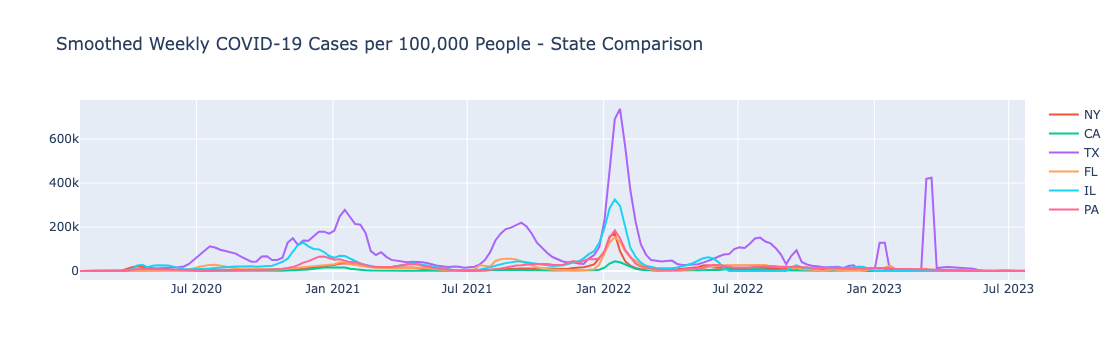

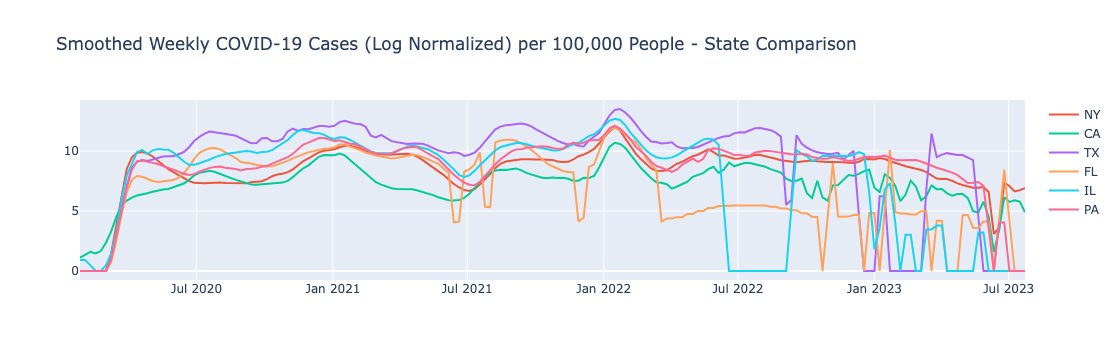

In [38]:
import plotly.express as px
import numpy as np

# the states chosen to compare
comparison_states = ['CA', 'TX', 'FL', 'IL', 'PA']
state_weekly_data = {}

for state in comparison_states:
    
    state_data = covid_data[covid_data['State'] == state]
    
    # reshaping
    state_cases = state_data.melt(
        id_vars=['countyFIPS', 'County Name', 'State', 'population'],
        value_vars=[col for col in state_data.columns if '_cases' in col and 'StateFIPS' not in col],
        var_name='date',
        value_name='cases'
    )
    state_cases['date'] = state_cases['date'].str.replace('_cases', '')

    state_deaths = state_data.melt(
        id_vars=['countyFIPS', 'County Name', 'State', 'population'],
        value_vars=[col for col in state_data.columns if '_deaths' in col and 'StateFIPS' not in col],
        var_name='date',
        value_name='deaths'
    )
    state_deaths['date'] = state_deaths['date'].str.replace('_deaths', '')

    # merging into single dataframe
    state_long_data = pd.merge(state_cases, state_deaths, on=['countyFIPS', 'County Name', 'State', 'population', 'date'])

    # converting 'date' to datetime
    state_long_data['date'] = pd.to_datetime(state_long_data['date'], format='%Y-%m-%d', errors='coerce')

    # removing doubles
    state_long_data = state_long_data.groupby(state_long_data['date']).sum()

    # calc daily counts 
    state_long_data['cases'] = state_long_data['cases'].diff().fillna(0).clip(lower=0)
    state_long_data['deaths'] = state_long_data['deaths'].diff().fillna(0).clip(lower=0)

    # resample 
    weekly_state_data = state_long_data.resample('W').sum()

    # normalizing
    state_population = state_data['population'].iloc[0]
    weekly_state_data['cases_per_100k'] = (weekly_state_data['cases'] / state_population) * 100000
    weekly_state_data['deaths_per_100k'] = (weekly_state_data['deaths'] / state_population) * 100000

    # log normalization
    weekly_state_data['log_cases_per_100k'] = weekly_state_data['cases_per_100k'].apply(lambda x: np.log1p(x))  # log(1+x) to avoid log(0) errors
    weekly_state_data['log_deaths_per_100k'] = weekly_state_data['deaths_per_100k'].apply(lambda x: np.log1p(x))

    # 2 week rolling mean to smooth the weekly data
    weekly_state_data['cases_per_100k'] = weekly_state_data['cases_per_100k'].rolling(window=2, min_periods=1).mean()
    weekly_state_data['deaths_per_100k'] = weekly_state_data['deaths_per_100k'].rolling(window=2, min_periods=1).mean()

    # log-normalized values smoothing
    weekly_state_data['log_cases_per_100k'] = weekly_state_data['log_cases_per_100k'].rolling(window=2, min_periods=1).mean()
    weekly_state_data['log_deaths_per_100k'] = weekly_state_data['log_deaths_per_100k'].rolling(window=2, min_periods=1).mean()

    # data in a dictionary
    state_weekly_data[state] = weekly_state_data

# smoothing to New York data
weekly_ny_data['cases_per_100k'] = weekly_ny_data['cases_per_100k'].rolling(window=2, min_periods=1).mean()
weekly_ny_data['deaths_per_100k'] = weekly_ny_data['deaths_per_100k'].rolling(window=2, min_periods=1).mean()

# log normalization for New York
weekly_ny_data['log_cases_per_100k'] = weekly_ny_data['cases_per_100k'].apply(lambda x: np.log1p(x))
weekly_ny_data['log_deaths_per_100k'] = weekly_ny_data['deaths_per_100k'].apply(lambda x: np.log1p(x))

# smoothing log normalized for New York
weekly_ny_data['log_cases_per_100k'] = weekly_ny_data['log_cases_per_100k'].rolling(window=2, min_periods=1).mean()
weekly_ny_data['log_deaths_per_100k'] = weekly_ny_data['log_deaths_per_100k'].rolling(window=2, min_periods=1).mean()

# plot to compare raw values
fig = px.line(title='Smoothed Weekly covid cases per 100,000 People - State Comparison')
fig.add_scatter(x=weekly_ny_data.index, y=weekly_ny_data['cases_per_100k'], mode='lines', name='NY')

for state, data in state_weekly_data.items():
    fig.add_scatter(x=data.index, y=data['cases_per_100k'], mode='lines', name=state)

fig.show()

# plot for log normalized 
fig_log = px.line(title='Smoothed Weekly covid cases (Log Normalized) per 100,000 People - State Comparison')
fig_log.add_scatter(x=weekly_ny_data.index, y=weekly_ny_data['log_cases_per_100k'], mode='lines', name='NY')

for state, data in state_weekly_data.items():
    fig_log.add_scatter(x=data.index, y=data['log_cases_per_100k'], mode='lines', name=state)

fig_log.show()


In Step 4, I looked at the weekly covid cases per 100,000 people for six states: California, Texas, Florida, Illinois, Pennsylvania, and New York. I selected and filtered the data for these states and organized it so that dates, cases, and deaths were easier to work with. I calculated the daily new cases and deaths for each state and added them up to get weekly totals. 


The graphs showed how weekly cases per 100,000 people changed over time in each state. There were peaks that showed different stages of the pandemic and how each state was affected at different times. Texas had a big spike in early 2022, meaning there was a large increase in covid cases there compared to the other states. This spike could be due to new variants non strict rules, holidays and traveling etc

I also used log normalization to handle the wide range of case numbers. The second graph shows the log normalized weekly covid cases per 100,000 people. This made the high peaks less extreme and allowed for a better comparison of lower numbers between states.  the lognormalized was easier to see trends in states with fewer cases because the huge spikes in places like Texas didn’t overshadow the smaller changes in other states. 
 Illinois shows a more steady increase in cases compared to Texas and Florida, which have bigger and more dramatic peaks. States like Illinois, Pennsylvania, and California have smoother trends over time without as many sharp spikes. This probably happens because these states had different public health responses, population densities, and how well people followed safety measures. The log-normalized data clearly shows that while Texas experienced sudden and intense outbreaks, Illinois had a slower and more controlled rise in cases. This difference might be due to the various ways each state managed the pandemic.

## Step 5: Identify top 5 counties in New York based on case rates per 100,000 and plot them

         County Name  cases_per_100k  deaths_per_100k
42  Richmond County     2.880421e+07    485056.380121
29    Nassau County     2.578975e+07    291588.254022
51   Suffolk County     2.488538e+07    290912.236955
43  Rockland County     2.477774e+07    281990.490778
40    Queens County     2.399892e+07    543811.544472


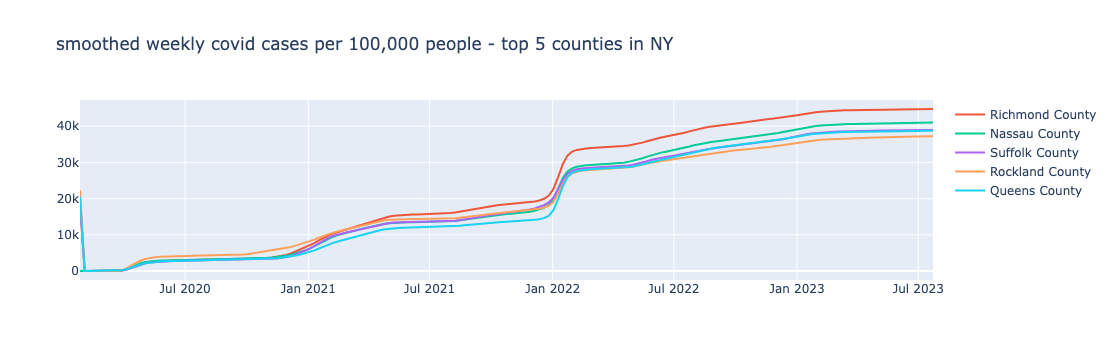

In [45]:
import pandas as pd
import plotly.express as px
# loading covid data
covid_data_path = '~/Desktop/sara individual work stage 2/covid 19 data/final_merged_data.csv'  
covid_data = pd.read_csv(covid_data_path)

# filter to New York 
ny_data = covid_data[covid_data['State'] == 'NY']

# reshaping
ny_cases = ny_data.melt(
    id_vars=['countyFIPS', 'County Name', 'State', 'population'],
    value_vars=[col for col in ny_data.columns if '_cases' in col and 'StateFIPS' not in col],
    var_name='date',
    value_name='cases'
)
ny_cases['date'] = ny_cases['date'].str.replace('_cases', '')

ny_deaths = ny_data.melt(
    id_vars=['countyFIPS', 'County Name', 'State', 'population'],
    value_vars=[col for col in ny_data.columns if '_deaths' in col and 'StateFIPS' not in col],
    var_name='date',
    value_name='deaths'
)
ny_deaths['date'] = ny_deaths['date'].str.replace('_deaths', '')

# cases and deaths single frame
ny_long_data = pd.merge(ny_cases, ny_deaths, on=['countyFIPS', 'County Name', 'State', 'population', 'date'])

# converting 'date' to datetime
ny_long_data['date'] = pd.to_datetime(ny_long_data['date'], format='%Y-%m-%d', errors='coerce')

# Calculate cumulative totals for each county
ny_totals = ny_long_data.groupby('County Name').agg({
    'cases': 'sum',
    'deaths': 'sum',
    'population': 'first'
}).reset_index()

# normalize totals per 100,000 people
ny_totals['cases_per_100k'] = (ny_totals['cases'] / ny_totals['population']) * 100000
ny_totals['deaths_per_100k'] = (ny_totals['deaths'] / ny_totals['population']) * 100000

# finding the top 5 counties by cases per 100,000
top_5_counties = ny_totals.nlargest(5, 'cases_per_100k')

# print 
print(top_5_counties[['County Name', 'cases_per_100k', 'deaths_per_100k']])

# plot trends for the top 5 counties
top_5_counties_list = top_5_counties['County Name'].tolist()

# filtering for only the top 5 counties
ny_top_5_long_data = ny_long_data[ny_long_data['County Name'].isin(top_5_counties_list)]

# ensuring 'date' is the index 
ny_top_5_long_data.set_index('date', inplace=True)

# resampling again
weekly_ny_top_5_data = ny_top_5_long_data.groupby(['County Name', pd.Grouper(freq='W')]).sum()

# normalizing again for population
weekly_ny_top_5_data['cases_per_100k'] = (weekly_ny_top_5_data['cases'] / weekly_ny_top_5_data['population']) * 100000
weekly_ny_top_5_data['deaths_per_100k'] = (weekly_ny_top_5_data['deaths'] / weekly_ny_top_5_data['population']) * 100000

#  2 week rolling mean to smooth the weekly data
weekly_ny_top_5_data['cases_per_100k'] = weekly_ny_top_5_data['cases_per_100k'].rolling(window=2, min_periods=1).mean()
weekly_ny_top_5_data['deaths_per_100k'] = weekly_ny_top_5_data['deaths_per_100k'].rolling(window=2, min_periods=1).mean()

# plot for each county thats in top 5
fig = px.line(title='smoothed weekly covid cases per 100,000 people - top 5 counties in NY')
for county in top_5_counties_list:
    county_data = weekly_ny_top_5_data[weekly_ny_top_5_data.index.get_level_values('County Name') == county]
    fig.add_scatter(x=county_data.index.get_level_values('date'), y=county_data['cases_per_100k'], mode='lines', name=county)


fig.show()

Step 5 focuses on analyzing New York data. It starts by filtering the dataset for New York counties, reshaping the data for easier analysis, and merging cases with deaths.  it calculates the total cases and deaths for each county and adjusts these numbers per 100,000 people to allow fair comparisons. The top five counties with the highest case rates are identified and displayed. Finally, the code plots the weekly trends for these counties, smoothing the data with a 2 week average to clearly show how covid cases changed over time. The output highlights that Richmond, Nassau, Suffolk, Rockland, and Queens had the highest case rates, with Richmond leading the way.


for step 5 the graph shows the number of weekly covid cases from July 2020 to July 2023 for Richmond, Nassau, Suffolk, Rockland, and Queens Counties. On the x-axis, the timeline spans from mid-2020 to mid-2023, while the y-axis displays cases per 100,000 people. all counties had low case numbers, but there was a sharp increase in early 2021, especially in Richmond County. After mid-2021, the cases began to level off, likely due to vaccinations and other health measures. Despite having larger populations, Nassau and Queens had lower case rates than Richmond, highlighting how factors like population density and public health responses affected each county differently. By 2022, the growth of cases slowed down, showing better management of the pandemic. 

## Step 6: Plot weekly trends for the top 5 counties within New York.

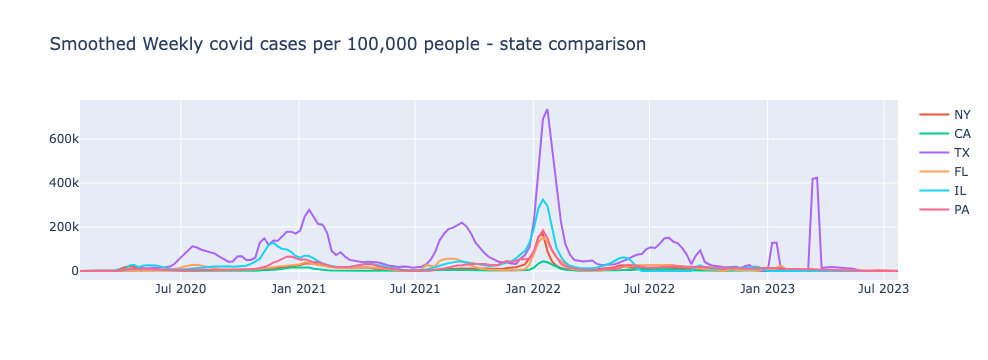

In [26]:
import plotly.express as px


comparison_state_list = ['CA', 'TX', 'FL', 'IL', 'PA']
state_weekly_dataset_dict = {}

for current_state in comparison_state_list:
    
    current_state_data = covid_data[covid_data['State'] == current_state]
    
    
    state_cases_long_format = current_state_data.melt(
        id_vars=['countyFIPS', 'County Name', 'State', 'population'],
        value_vars=[col for col in current_state_data.columns if '_cases' in col and 'StateFIPS' not in col],
        var_name='date',
        value_name='cases'
    )
    state_cases_long_format['date'] = state_cases_long_format['date'].str.replace('_cases', '')

    state_deaths_long_format = current_state_data.melt(
        id_vars=['countyFIPS', 'County Name', 'State', 'population'],
        value_vars=[col for col in current_state_data.columns if '_deaths' in col and 'StateFIPS' not in col],
        var_name='date',
        value_name='deaths'
    )
    state_deaths_long_format['date'] = state_deaths_long_format['date'].str.replace('_deaths', '')

  
    state_combined_long_format = pd.merge(state_cases_long_format, state_deaths_long_format, 
                                          on=['countyFIPS', 'County Name', 'State', 'population', 'date'])

   
    state_combined_long_format['date'] = pd.to_datetime(state_combined_long_format['date'], format='%Y-%m-%d', errors='coerce')

   
    state_combined_long_format = state_combined_long_format.groupby(state_combined_long_format['date']).sum()

    
    state_combined_long_format['cases'] = state_combined_long_format['cases'].diff().fillna(0).clip(lower=0)
    state_combined_long_format['deaths'] = state_combined_long_format['deaths'].diff().fillna(0).clip(lower=0)

    
    weekly_combined_state_data = state_combined_long_format.resample('W').sum()

    
    state_population_value = current_state_data['population'].iloc[0]
    weekly_combined_state_data['cases_per_100k'] = (weekly_combined_state_data['cases'] / state_population_value) * 100000
    weekly_combined_state_data['deaths_per_100k'] = (weekly_combined_state_data['deaths'] / state_population_value) * 100000

    
    weekly_combined_state_data['cases_per_100k'] = weekly_combined_state_data['cases_per_100k'].rolling(window=2, min_periods=1).mean()
    weekly_combined_state_data['deaths_per_100k'] = weekly_combined_state_data['deaths_per_100k'].rolling(window=2, min_periods=1).mean()

    
    state_weekly_dataset_dict[current_state] = weekly_combined_state_data


weekly_ny_data['cases_per_100k'] = weekly_ny_data['cases_per_100k'].rolling(window=2, min_periods=1).mean()
weekly_ny_data['deaths_per_100k'] = weekly_ny_data['deaths_per_100k'].rolling(window=2, min_periods=1).mean()


fig = px.line(title='Smoothed Weekly covid cases per 100,000 people - state comparison')
fig.add_scatter(x=weekly_ny_data.index, y=weekly_ny_data['cases_per_100k'], mode='lines', name='NY')

for current_state, data in state_weekly_dataset_dict.items():
    fig.add_scatter(x=data.index, y=data['cases_per_100k'], mode='lines', name=current_state)

fig.show()


 filtered and merged and calulated data and smoothed, etc and the results conclude the line chart shows that TX and IL had the highest spikes in cases, especially during late 2021 and early 2022, likely due to new covid variants. Other states like CA, FL, PA, and NY also saw increases but not as severe. Holidays also are a factor the case numbers, as gatherings and increased travel during times like Thanksgiving and Christmas may have contributed to the spikes in covid cases. Because more close contact make it harder to maintain safety measures, resulting the trends in the graph.
